# Pysoccer library

## 1. Import libraries

In [1]:
from pysoccer.attributes import *
from pysoccer.event import *
from pysoccer.serializers.WyscoutSerializer.eventSerializer import *
from pysoccer.serializers.WyscoutSerializer.matchSerializer import *
import json
from collections import defaultdict
from collections import Counter
import numpy as np
import operator
import matplotlib.pyplot as plt 
import pandas as pd
from pysoccer.FCPython import createPitch

## 2. Load public dataset

We import the *matches* and *event* data sets from the data folder we stored them before.

In [2]:
matches, events = {}, {}
with open('./pysoccer/data/events/events_%s.json' %'Italy') as json_data:
    events = json.load(json_data)
with open('./pysoccer/data/matches/matches_%s.json' %'Italy') as json_data:
    matches = json.load(json_data)

We now create two dictionaries containing *matches* and *event*. We use respectively the *wyId* and the *matchID* as keys for the values.

In [3]:
match_id2events = defaultdict(list)
match_id2match = defaultdict(dict)
for event in events:
    match_id = event['matchId']
    match_id2events[match_id].append(event)                                     
for match in matches:
    match_id = match['wyId']
    match_id2match[match_id] = match

## 3. Structure of data

### 3.A. Matches

In [4]:
a_match = list(match_id2match.keys())[0]
match_id2match[a_match]

{'status': 'Played',
 'roundId': 4406278,
 'gameweek': 38,
 'teamsData': {'3162': {'scoreET': 0,
   'coachId': 251025,
   'side': 'home',
   'teamId': 3162,
   'score': 2,
   'scoreP': 0,
   'hasFormation': 1,
   'formation': {'bench': [{'playerId': 4792,
      'ownGoals': '2',
      'redCards': '93',
      'goals': '0',
      'yellowCards': '0'},
     {'playerId': 20972,
      'ownGoals': '0',
      'redCards': '0',
      'goals': 'null',
      'yellowCards': '0'},
     {'playerId': 256479,
      'ownGoals': '0',
      'redCards': '0',
      'goals': 'null',
      'yellowCards': '0'},
     {'playerId': 241675,
      'ownGoals': '0',
      'redCards': '0',
      'goals': 'null',
      'yellowCards': '0'},
     {'playerId': 260250,
      'ownGoals': '0',
      'redCards': '0',
      'goals': 'null',
      'yellowCards': '0'},
     {'playerId': 69417,
      'ownGoals': '0',
      'redCards': '0',
      'goals': 'null',
      'yellowCards': '0'},
     {'playerId': 20460,
      'ownGoals':

### 3.B. Events

In [5]:
match_id2events[a_match][0]

{'eventId': 8,
 'subEventName': 'Simple pass',
 'tags': [{'id': 1801}],
 'playerId': 3344,
 'positions': [{'y': 50, 'x': 49}, {'y': 58, 'x': 38}],
 'matchId': 2576335,
 'eventName': 'Pass',
 'teamId': 3161,
 'matchPeriod': '1H',
 'eventSec': 2.4175900000000183,
 'subEventId': 85,
 'id': 253668302}

## 4. Serializing

### 4.A. Serializing Events

We then create a new object *WyscoutSerializer* that will do the serialization for us. We can call the *serialize* function that needs a list of Wyscout events as input and will return a list of standardized events.

In [6]:
event_serializer = WyscoutEventSerializer()
events = event_serializer.serialize(match_id2events[a_match])

[WyscoutEventSerializer] events serialized. 1768 events processed


In *events* now we will find our list of standardized events. Below you can see how a standardized event looks.

In [7]:
events[0]

PossessionEvent(event_id=253668302, team_id=3161, player_id=3344, match_id=2576335, period='1H', timestamp=2.4175900000000183, start_position=Point(x=49, y=50), end_position=Point(x=38, y=58), outcome='success', label='Pass-Simple pass-success', tags=[1801], phase_id=0, phase_end='ball lost', phase_possessing_team=3161, is_duel=False, challenged_player=None, is_shot=False, goal_position=None, is_goal=False, is_pass=True, receiver_player_id=116349, is_assist=False, is_keypass=False)

We see that it is a *PossessionEvent*, precisely a pass. It was accurate and the ball passed from the player with id 3344 to the player with id 116349.

### 3.B. Serializing Matches

In the same way we did for events we can create a new object *WyscoutMatchSerializer* that will serializer our matches. We call the *serialize* function that needs a dict containing Wyscout matches as values and Wyscout match_ids as keys as input. Then the function will return a dictionary containing serialized matches as values and the same keys.

In [8]:
match_serializer = WyscoutMatchSerializer()
matches = match_serializer.serialize(match_id2match)

We can see that the *matches*'s value for the *a_match* key is a standardized match that looks as follow.

In [9]:
matches[a_match]

Match(competition_id=524, round_id=4406278, season_id=181248, date_utc='2018-05-20 18:45:00', match_id=2576335, label='Lazio - Internazionale, 2 - 3', home_team=Team(team_id='3162', coach_id=251025, score=2, formation=Formation(lineup=[Player(player_id=21384, played_minutes=15, yellow_cards='0', red_cards='0', own_goals='2', goals='0'), Player(player_id=20550, played_minutes=13, yellow_cards='0', red_cards='0', own_goals='2', goals='0'), Player(player_id=130, played_minutes=7, yellow_cards='0', red_cards='0', own_goals='0', goals='null'), Player(player_id=346908, played_minutes=90, yellow_cards='0', red_cards='0', own_goals='0', goals='null'), Player(player_id=376362, played_minutes=90, yellow_cards='25', red_cards='0', own_goals='0', goals='null'), Player(player_id=166534, played_minutes=90, yellow_cards='63', red_cards='0', own_goals='0', goals='null'), Player(player_id=20561, played_minutes=90, yellow_cards='33', red_cards='79', own_goals='2', goals='0'), Player(player_id=40806, pla

It's the *Lazio - Internazionale* match, played in the last round of the 2018 Serie A.

## 5. Basic statistics

We can try to serialize all the events in the data set.

In [10]:
serialized_events = {}
for id,events in match_id2events.items():
    serialized_events[id] = event_serializer.serialize(events)

[WyscoutEventSerializer] events serialized. 1784 events processed
[WyscoutEventSerializer] events serialized. 1685 events processed
[WyscoutEventSerializer] events serialized. 1599 events processed
[WyscoutEventSerializer] events serialized. 1863 events processed
[WyscoutEventSerializer] events serialized. 1868 events processed
[WyscoutEventSerializer] events serialized. 1870 events processed
[WyscoutEventSerializer] events serialized. 1930 events processed
[WyscoutEventSerializer] events serialized. 1851 events processed
[WyscoutEventSerializer] events serialized. 1649 events processed
[WyscoutEventSerializer] events serialized. 1919 events processed
[WyscoutEventSerializer] events serialized. 1711 events processed
[WyscoutEventSerializer] events serialized. 1791 events processed
[WyscoutEventSerializer] events serialized. 1784 events processed
[WyscoutEventSerializer] events serialized. 1659 events processed
[WyscoutEventSerializer] events serialized. 1815 events processed
[WyscoutEv

[WyscoutEventSerializer] events serialized. 1783 events processed
[WyscoutEventSerializer] events serialized. 1815 events processed
[WyscoutEventSerializer] events serialized. 1966 events processed
[WyscoutEventSerializer] events serialized. 1895 events processed
[WyscoutEventSerializer] events serialized. 1866 events processed
[WyscoutEventSerializer] events serialized. 1879 events processed
[WyscoutEventSerializer] events serialized. 1962 events processed
[WyscoutEventSerializer] events serialized. 1843 events processed
[WyscoutEventSerializer] events serialized. 2015 events processed
[WyscoutEventSerializer] events serialized. 2037 events processed
[WyscoutEventSerializer] events serialized. 1896 events processed
[WyscoutEventSerializer] events serialized. 1849 events processed
[WyscoutEventSerializer] events serialized. 1977 events processed
[WyscoutEventSerializer] events serialized. 1752 events processed
[WyscoutEventSerializer] events serialized. 1925 events processed
[WyscoutEv

[WyscoutEventSerializer] events serialized. 1996 events processed
[WyscoutEventSerializer] events serialized. 1964 events processed
[WyscoutEventSerializer] events serialized. 2089 events processed
[WyscoutEventSerializer] events serialized. 1922 events processed
[WyscoutEventSerializer] events serialized. 2061 events processed
[WyscoutEventSerializer] events serialized. 1986 events processed
[WyscoutEventSerializer] events serialized. 1868 events processed
[WyscoutEventSerializer] events serialized. 1897 events processed
[WyscoutEventSerializer] events serialized. 1816 events processed
[WyscoutEventSerializer] events serialized. 1798 events processed
[WyscoutEventSerializer] events serialized. 1854 events processed
[WyscoutEventSerializer] events serialized. 1912 events processed
[WyscoutEventSerializer] events serialized. 1754 events processed
[WyscoutEventSerializer] events serialized. 1884 events processed
[WyscoutEventSerializer] events serialized. 1931 events processed
[WyscoutEv

[WyscoutEventSerializer] events serialized. 1830 events processed


### 5.A. Frequency of label per type

For each label we plot how frequent it is in the serialized data set.

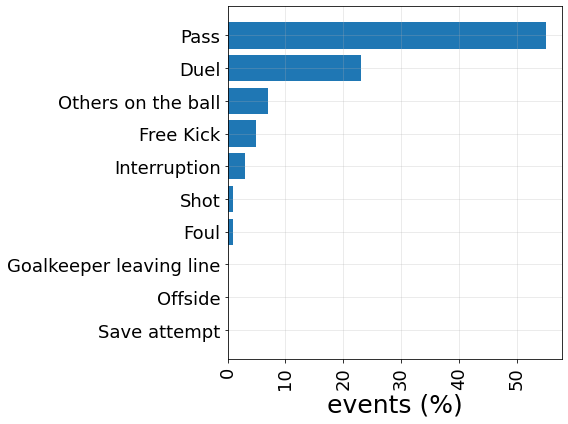

In [11]:
events_list = []
for match_id, events in serialized_events.items():
    for event in events:
        events_list.append(event.label.split("-")[0])

count = Counter(events_list)
counter = {}
for i, n_events in zip(count.keys(), count.values()):
    counter[i] = int(float(n_events)/len(events_list)*100)
sorted_d = np.array(sorted(counter.items(), key=operator.itemgetter(1), reverse=False))

fig, ax = plt.subplots(figsize=(8,6))
plt.barh(list(sorted_d[:,0]),[int(x) for x in list(sorted_d[:,1])])
plt.xticks(rotation=90);plt.xticks(fontsize=18)
plt.xlabel('events (%)', fontsize=25)
plt.yticks(fontsize=18)
plt.grid(alpha=0.3)
fig.tight_layout()
plt.show()

### 5.B. Distribution of the number of events per match

We can compute the number of events in each match. We the plot the distribution of this quantity.

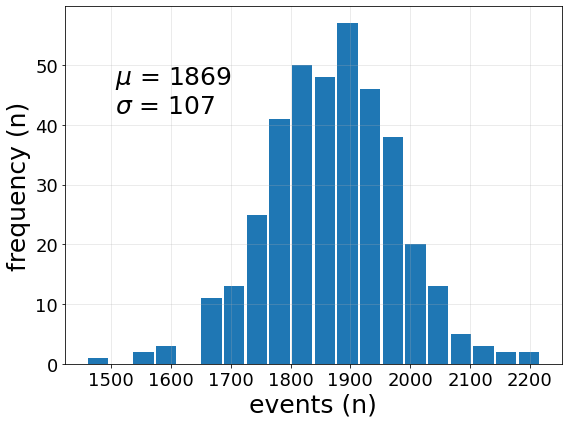

In [12]:
values = [len(events) for events in serialized_events.values()]
avg_n_events = np.mean(values)
std_n_events = np.std(values)

fig, ax = plt.subplots(figsize=(8,6))
plt.hist(values, rwidth=0.9, bins=20)
plt.grid(alpha=0.3)
plt.yticks(fontsize=18)
plt.xlabel('events (n)', fontsize=25)
plt.ylabel('frequency (n)', fontsize=25)
plt.xticks(fontsize=18)
plt.text(0.1, 0.7,
        '$\mu$ = %i\n$\sigma$ = %i'%(avg_n_events, std_n_events),
        fontsize=25, transform=ax.transAxes)
fig.tight_layout()
plt.show()

## 6. Plot events on the field

It is possible to create a *pandas DataFrame* with the standardized event's attributes. Let's take an Italian Serie A match and create a *DataFrame* for its events.

In [13]:
match_id = 2576335
match_events = []
for event in serialized_events[match_id]:
    match_events.append(event.to_dict())

match_df = pd.DataFrame(match_events)
match_df.head()

,event_id,team_id,player_id,match_id,period,timestamp,start_position,end_position,outcome,label,...,challenged_player,is_shot,goal_position,is_goal,is_pass,receiver_player_id,is_assist,is_keypass,is_foul,card
0,253668302,3161,3344,2576335,1H,2.417590,"Point(x=49, y=50)","Point(x=38, y=58)",success,Pass-Simple pass-success,...,NaN,False,None,False,True,116349.0,False,False,NaN,NaN
1,253668303,3161,116349,2576335,1H,3.904412,"Point(x=38, y=58)","Point(x=37, y=91)",success,Pass-Simple pass-success,...,NaN,False,None,False,True,135903.0,False,False,NaN,NaN
2,253668304,3161,135903,2576335,1H,6.484211,"Point(x=37, y=91)","Point(x=34, y=72)",success,Pass-Simple pass-success,...,NaN,False,None,False,True,138408.0,False,False,NaN,NaN
3,253668306,3161,138408,2576335,1H,10.043835,"Point(x=34, y=72)","Point(x=36, y=14)",success,Pass-Simple pass-success,...,NaN,False,None,False,True,21094.0,False,False,NaN,NaN
4,253668308,3161,21094,2576335,1H,14.032070,"Point(x=36, y=14)","Point(x=30, y=39)",success,Pass-Simple pass-success,...,NaN,False,None,False,True,3431.0,False,False,NaN,NaN


Then we can plot them on a pitch.

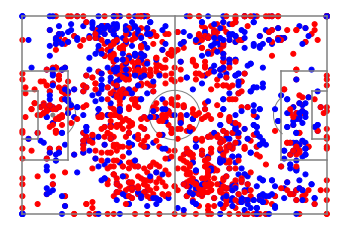

In [14]:
(fig,ax) = createPitch(120,80,'yards','gray')
for i,event in match_df.iterrows():
    if (event['team_id']==3161):
        x=((event['start_position'].x)*120)/100
        y=((event['start_position'].y)*80)/100
        shotCircle=plt.Circle((x,y),1,color='red')
    elif (event['team_id']==3162):
        x=((100-event['start_position'].x)*120)/100
        y=((100-event['start_position'].y)*80)/100
        shotCircle=plt.Circle((x,y),1,color='blue')
    ax.add_patch(shotCircle)

plt.show()

If we want to visualize all the shot that the players took during the match, it is possible to select them from the *DataFrame* and plot them as well. To add something interesting we also highlight the goals.

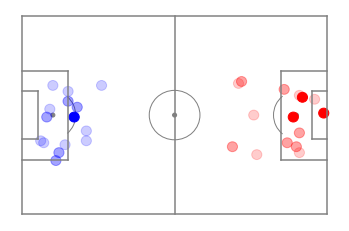

In [15]:
(fig,ax) = createPitch(120,80,'yards','gray')

for event in serialized_events[match_id]:
    try:
        if event.is_shot:
            if event.team_id == 3161:
                point = event.get_position(120,80,'R')
                shotCircle = plt.Circle((point.x,point.y),2,color='red')
            elif event.team_id == 3162:
                point = event.get_position(120,80,'L')
                shotCircle = plt.Circle((point.x,point.y),2,color='blue')
            if not event.is_goal:
                shotCircle.set_alpha(.2)
            ax.add_patch(shotCircle)
    except AttributeError:
        pass

plt.show()
        

The chosen match is Lazio-Internazionale 3-2. Our plot is not incorrect, it shows four goals beacuse during the match Ivan Perisic scored an own goal. It is interesting to see the shot taken during a penalty that took to a goal.

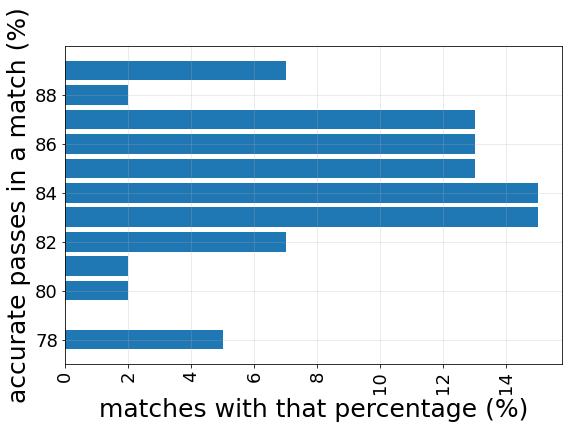

In [31]:
match_accurate = []
match_passes = []
for a_match in list(matches.keys()):
    accurate = 0
    passes = 0
    if '3161' in [matches[a_match].home_team.team_id, matches[a_match].away_team.team_id]:
        for event in serialized_events[a_match]:
            if event.team_id == 3161 and event.label.split("-")[0] == 'Pass':
                passes += 1
                if event.outcome == 'success':
                    accurate += 1
        match_passes.append(passes)
        match_accurate.append(accurate)

accurate_percentage = []

for accurate,passes in zip(match_accurate, match_passes):
    percentage = (accurate*100)/passes
    accurate_percentage.append(int(percentage))

count = Counter(accurate_percentage)
counter = {}
for i, n_percentages in zip(count.keys(), count.values()):
    counter[i] = int(float(n_percentages)/len(accurate_percentage)*100)
sorted_d = np.array(sorted(counter.items(), key=operator.itemgetter(1), reverse=False))

fig, ax = plt.subplots(figsize=(8,6))
plt.barh(list(sorted_d[:,0]),[int(x) for x in list(sorted_d[:,1])])
plt.xticks(rotation=90);plt.xticks(fontsize=18)
plt.xlabel('matches with that percentage (%)', fontsize=25)
plt.ylabel('accurate passes in a match (%)', fontsize=25)
plt.yticks(fontsize=18)
plt.grid(alpha=0.3)
fig.tight_layout()
plt.show()

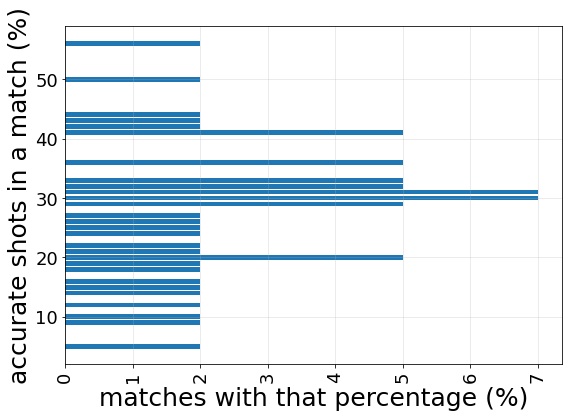

In [33]:
match_accurate_shots = []
match_shots = []
for a_match in list(matches.keys()):
    accurate = 0
    shots = 0
    if '3161' in [matches[a_match].home_team.team_id, matches[a_match].away_team.team_id]:
        for event in serialized_events[a_match]:
            if event.team_id == 3161 and event.label.split("-")[0] == 'Shot':
                shots += 1
                if event.outcome == 'success':
                    accurate += 1
        match_shots.append(shots)
        match_accurate_shots.append(accurate)

accurate_percentage = []

for accurate,shots in zip(match_accurate_shots, match_shots):
    percentage = (accurate*100)/shots
    accurate_percentage.append(int(percentage))
    
count = Counter(accurate_percentage)
counter = {}
for i, n_percentages in zip(count.keys(), count.values()):
    counter[i] = int(float(n_percentages)/len(accurate_percentage)*100)
sorted_d = np.array(sorted(counter.items(), key=operator.itemgetter(1), reverse=False))

fig, ax = plt.subplots(figsize=(8,6))
plt.barh(list(sorted_d[:,0]),[int(x) for x in list(sorted_d[:,1])])
plt.xticks(rotation=90);plt.xticks(fontsize=18)
plt.xlabel('matches with that percentage (%)', fontsize=25)
plt.ylabel('accurate shots in a match (%)', fontsize=25)
plt.yticks(fontsize=18)
plt.grid(alpha=0.3)
fig.tight_layout()
plt.show()